In [44]:
%matplotlib inline

In [67]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='grade3')
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(1980)
import sys
sys.path.insert(0, '/Users/avivb/mehcoeg/code/Python')
from scipy.stats import multivariate_normal, gaussian_kde
import scipy
import pdb

# random walk example

In [71]:
#model and data:
f = lambda x: x + np.random.normal(size = x.shape)
g = lambda y: y + np.random.normal(size = y.shape)
X0 = 0
t = range(-100, 0)
z = np.cumsum(np.random.normal(loc=0, scale=1, size=(len(t)) ))

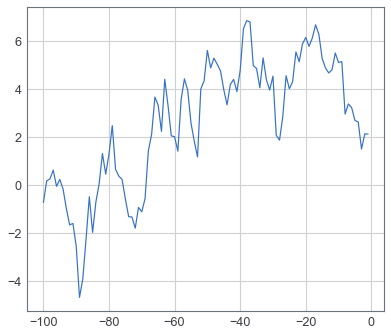

In [72]:
plt.plot(t, z)

In [73]:
#bootstrap PF calulations
N_particles = 1000
N_timesteps = len(t)
X = np.zeros((N_timesteps, N_particles))
Y = np.zeros((N_timesteps, N_particles))
X[0,:] = X0
X[0,:] = f(X[0, :])
Y[0,:] = g(X[0, :])

In [74]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [75]:
print( X[0, :] )[:5]

[-0.88 0.38 -0.30 -1.71 -0.99]


Text(0,0.5,u'$p(X_0)$')

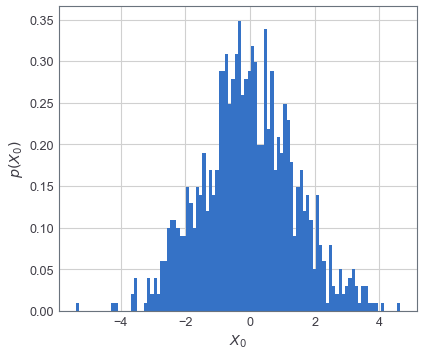

In [76]:
plt.hist(f(X[0, :]),bins=100, density=True );
plt.xlabel('$X_0$')
plt.ylabel('$p(X_0)$')
# plt.savefig('../../Figures/PF_simple_example_P(X0)')

In [77]:
X[1, :] = f(X[0, :])
Y[1,:] = g(X[1, :])

In [86]:
def plot2dkde(m1, m2):
    
    def minmax(X):
        return X.min(), X.max()
    
    xmin, xmax = minmax(m1)
    ymin, ymax = minmax(m2) 
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
#     pdb.set_trace()
    kernel = gaussian_kde(values)
    
    Z = np.reshape(kernel(positions).T, X.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
              extent=[xmin, xmax, ymin, ymax])
    ax.plot(m1, m2, 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.show()
    

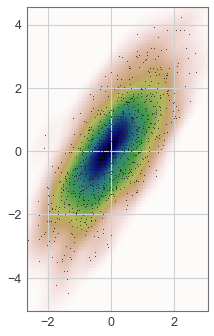

In [87]:
plot2dkde(X[0,:], X[1,:])

# Nonlinear equation example

In [ ]:
np.random.seed(1980)

#sample time
dT = 1
#observation times
t = range(0, 75, dT)

#process noise (standard deviation)
q = 10
wk = np.sqrt(q)

#measurement noise (standard deviation)
r = 1
vk = np.sqrt(r)

#state at t=0
X0 = 0 + np.random.randn(1)*np.sqrt(5)

#simulate true state for x at the observation times
X = np.empty(shape=(len(t),1))
Y = np.empty(shape=(len(t),1))
X[0] = X0
Y[0] = (X[0]**2)/20

for k in range(len(t)-1):
    X[k+1] = X[k]/2 + 25*X[k]/(1 + X[k]**2) + 8*np.cos(1.2*k) + np.random.randn()*wk
    Y[k+1] = (X[k+1]**2)/20 +  np.random.randn(1)*vk

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
#plot simulated states
plt.plot(t, X, "-b");
plt.xlabel("Time");
plt.ylabel("X");

plt.subplot(1,2,2)
#plot measurements
plt.plot(t, X, "-r");
plt.xlabel("Time");
plt.ylabel("Y");


In [ ]:
class PF:
    def __init__(self, process_model, observation_model, 
                 process_error, obervation_error, 
                 initial_state_estimate_error, 
                 initial_state_estimate, 
                 observations, n_particles):
        
        self.F = process_model
        self.G = observation_model
        self.Q = process_error
        self.R = obervation_error
        self.X0 = initial_state_estimate
        self.P0 = initial_state_estimate_error
        self.y = observations
        self.N = n_particles
        
    def filter(self):
        #initial particles and weights
        xp = multivariate_normal.rvs(mean=self.X0, cov=self.P0, size=(self.N, 1))
        w = np.array([1./self.N]*self.N).reshape(self.N, 1)
        
        for k in range(len(self.y)):
            #propagate particles through state eqs
            wks = multivariate_normal.rvs(cov=self.Q, size=(self.N, 1)) 
            xp = map(lambda x: self.F(x, k), xp ) + wks 

            #propagate particles through obs eqs
            vks = multivariate_normal.rvs(cov=self.R, size=(self.N, 1)) 
            yp = map(lambda x: self.G(x, k), xp ) + vks 
            
            #update weights
            
            w /= w.sum()
            
#             print w[0]
            print '-----'
#             print np.dot(res.T, res)/self.R
            
            #resample particles
#             Neff = 1/np.dot(w, w.T)
#             print Neff
            
            
              
        

In [ ]:
def process_model(x, k):
    return x/2 + 25*x/(1 + x**2) + 8*np.cos(1.2*k)

def obs_model(x, k):
    return (x**2)/20

In [ ]:
pf = PF(process_model=process_model ,
        process_error=wk**2,
        observation_model=obs_model, 
        obervation_error=vk**2,
        initial_state_estimate=X[0],
        initial_state_estimate_error=5,        
        observations=Y,
        n_particles=500)

In [ ]:
pf.filter()